In [1]:
import os

In [2]:
os.listdir('dataset2-master/dataset2-master/images')

['.DS_Store', 'TEST', 'TEST_SIMPLE', 'TRAIN']

In [3]:
train_dir = 'dataset2-master/dataset2-master/images/TRAIN'
test_dir = 'dataset2-master/dataset2-master/images/TEST'

os.listdir(train_dir)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [32]:
batch_size = 2
ImageDataGenerator
train_gen = train_datagen.flow_from_directory(train_dir, batch_size=batch_size)
test_gen = test_datagen.flow_from_directory(test_dir, batch_size=batch_size)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


Show example image

In [13]:
x, y = next(train_gen)
x.shape, y.shape

((2, 256, 256, 3), (2, 4))

In [8]:
import matplotlib.pyplot as plt

In [9]:
import numpy as np

In [10]:
train_gen.class_indices

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [11]:
np.argmax(y[0])

3

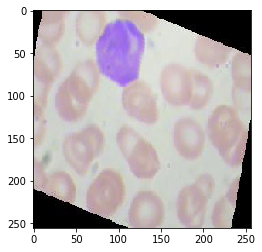

In [14]:
plt.imshow(x[0])
plt.show()

## Define our CNN model

In [17]:
kernel_size = (3, 3)
pool_size = (4, 4)

x_in = tf.keras.layers.Input(shape=(256, 256, 3))

x = tf.keras.layers.Conv2D(filters=8, kernel_size=kernel_size, activation='relu')(x_in)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=pool_size)(x)

x = tf.keras.layers.Conv2D(filters=16, kernel_size=kernel_size, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=pool_size)(x)
                              
x = tf.keras.layers.Conv2D(filters=32, kernel_size=kernel_size, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D(pool_size=pool_size)(x)
                              
x_flatten = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x_flatten)
x_out = tf.keras.layers.Dense(4, activation='softmax')(x)

In [18]:
model = tf.keras.Model(x_in, x_out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 8)       224       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 8)       32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 16)        0         
__________

In [19]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [24]:
model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=10,
    validation_data=test_gen,
    validation_steps=len(test_gen),
    workers=4,
)

Epoch 1/10
 779/9957 [=>............................] - ETA: 13:10 - loss: 1.4111 - acc: 0.2965

KeyboardInterrupt: 

In [72]:
os.listdir(train_dir)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [73]:
train_gen.class_indices

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [76]:
from skimage.io import imread

In [79]:
imgs = []
for folder in os.listdir(train_dir):
    label = train_gen.class_indices[folder]
    for path in os.listdir(os.path.join(train_dir, folder)):
        img = imread(os.path.join(train_dir, folder, path))
        imgs.append(img)
imgs = np.asarray(imgs)
imgs.shape

(9957, 240, 320, 3)

Transfer learning with InceptionV3

In [26]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [27]:
base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.summary()

87916544/87910968 [==============================] - 4s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, None, None, 3 96          conv2d_3[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_3[0][0]      
____________________________________________

In [28]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

In [29]:
model_transfer = tf.keras.Model(base_model.input, predictions)

In [30]:
for layer in base_model.layers:
    layer.trainable = False

In [36]:
model_transfer.compile(optimizer='adam', 
                       loss='categorical_crossentropy',
                       metrics=['acc'])

In [37]:
model_transfer.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=10,
    validation_data=test_gen,
    validation_steps=len(test_gen),
    workers=4,
)

Epoch 1/10
  69/4979 [..............................] - ETA: 2:23:38 - loss: 1.4734 - acc: 0.2174

KeyboardInterrupt: 

In [38]:
x, y = next(test_gen)
x.shape, y.shape

((2, 256, 256, 3), (2, 4))

In [41]:
y_pred = model_transfer.predict(x)
y_pred.shape

(2, 4)

In [42]:
y_pred[0]

array([0.13816223, 0.09474114, 0.2511867 , 0.51590997], dtype=float32)